In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K



df = pd.read_csv("ReadySoilDataset_Final.csv")
df = df[df['Region'].isin([2, 4, 5, 7])].reset_index(drop=True)
df.head(10)


,Region,Year,Month,SoilTemperature-10,SoilTemperature-30,SoilTemperature-50,Rainfall,Temperature,Min Temperature,Max Temperature,Humidity,Sunshine,Wind Speed,Surface Pressure,Solar Radiation
0,2,2001,1,17.40,18.81,19.43,0.0,18.38,13.04,25.44,62.68,7.94,2.17,101268.29,199.25
1,2,2001,2,19.88,19.98,20.36,1.0,22.61,16.90,28.56,61.71,7.19,1.98,101039.08,210.73
2,2,2001,3,24.08,23.32,23.17,33.0,26.62,20.73,31.84,55.48,8.75,2.10,100882.56,251.75
3,2,2001,4,27.62,27.02,26.77,46.0,29.06,24.71,32.06,65.63,8.55,2.70,100655.40,257.46
4,2,2001,5,28.54,28.29,28.21,402.0,27.69,24.18,32.09,77.39,6.10,2.37,100234.63,172.32
5,2,2001,6,30.11,29.82,29.64,386.0,28.03,25.55,31.75,83.17,3.51,3.64,99934.18,140.45
6,2,2001,7,30.74,30.53,30.64,202.0,28.83,25.92,31.60,80.26,4.55,3.87,99991.05,169.40
7,2,2001,8,30.99,30.99,30.86,205.0,29.46,25.23,31.50,82.19,5.15,3.01,100129.68,181.66
8,2,2001,9,29.83,29.89,29.95,209.0,28.71,24.34,32.42,82.53,4.65,2.14,100499.17,170.22
9,2,2001,10,28.00,28.29,28.50,177.0,27.63,22.83,31.44,80.45,5.60,1.59,100864.38,167.89


In [4]:
# Feature and target selection
features = df[['Month', 'Temperature', 'Min Temperature',
               'Max Temperature', 
               'Rainfall', 'Surface Pressure']]
target = df['SoilTemperature-50']

# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Sliding window
def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = create_sliding_window(scaled_features, scaled_target, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=2)

# Custom R² metric
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(32, return_sequences=True),
    GRU(32,return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(), loss='mse', metrics=[r2_score, 'mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Evaluate model
loss, r2, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")

# Predictions
predictions = model.predict(X_test)

# Rescale predictions and actuals
predictions_rescaled = target_scaler.inverse_transform(predictions)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Show comparison
comparison = pd.DataFrame({
    'Predicted': predictions_rescaled.flatten(),
    'Actual': y_test_rescaled.flatten()
})




print(comparison[:25])



Epoch 1/50


27/27 [==============================] - 8s 69ms/step - loss: 0.1026 - r2_score: -0.9717 - mae: 0.2410 - val_loss: 0.0160 - val_r2_score: 0.7112 - val_mae: 0.1044
Epoch 2/50
27/27 [==============================] - 1s 20ms/step - loss: 0.0211 - r2_score: 0.6375 - mae: 0.1087 - val_loss: 0.0087 - val_r2_score: 0.8481 - val_mae: 0.0719
Epoch 3/50
27/27 [==============================] - 0s 18ms/step - loss: 0.0175 - r2_score: 0.6906 - mae: 0.1021 - val_loss: 0.0097 - val_r2_score: 0.8300 - val_mae: 0.0766
Epoch 4/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0177 - r2_score: 0.6821 - mae: 0.1012 - val_loss: 0.0088 - val_r2_score: 0.8457 - val_mae: 0.0733
Epoch 5/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0157 - r2_score: 0.7090 - mae: 0.0942 - val_loss: 0.0067 - val_r2_score: 0.8861 - val_mae: 0.0612
Epoch 6/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0149 - r2_score: 0.7472 - mae: 0.0939 - val_loss: 0.0069

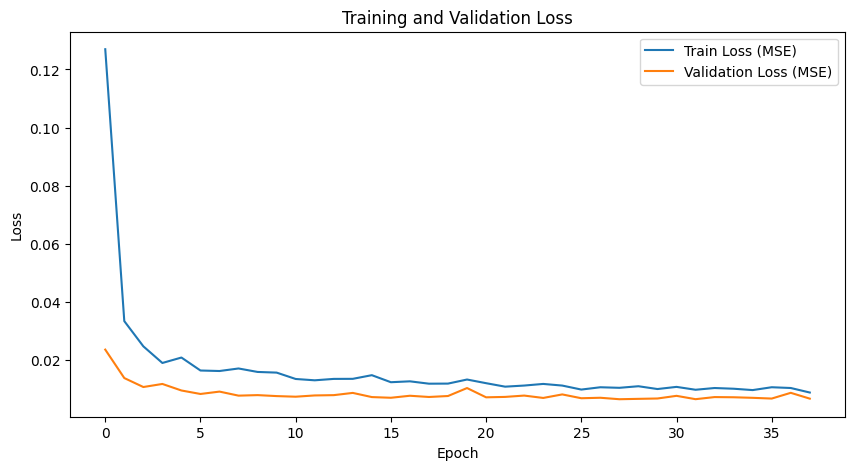

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

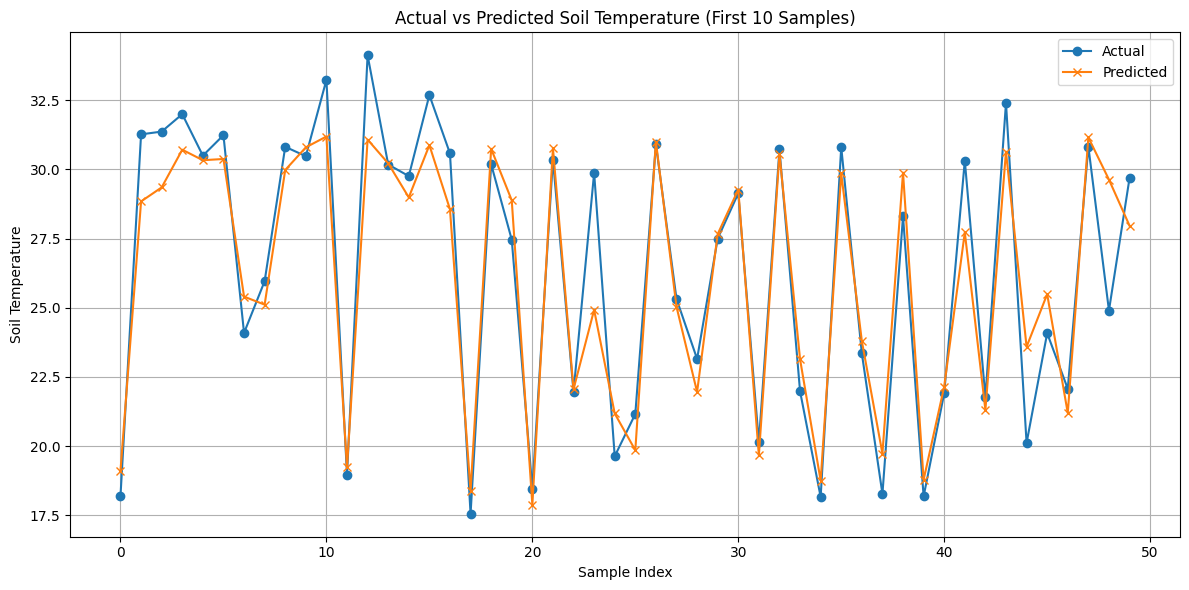

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(comparison['Actual'].values[:50], label='Actual', marker='o')
plt.plot(comparison['Predicted'].values[:50], label='Predicted', marker='x')
plt.title('Actual vs Predicted Soil Temperature (First 10 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Soil Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
